<a href="https://colab.research.google.com/github/abao1999/Embryos/blob/main/notebooks/pix2pix_PyTorch_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Adapted from https://github.com/eriklindernoren/PyTorch-GAN

In [ ]:
import os
from google.colab import files, drive   

# mount the google drive to my Colab session
drive.mount('/content/gdrive')
# use the google drive in my Colab session
print(os.listdir('/content/gdrive/My Drive/'))

Mounted at /content/gdrive
['Share_with_me', 'My OnePlus One', 'Colab Notebooks', 'Dataset', 'CS101 PS5', 'FPM experiment', 'Shared_files']


### datasets

In [ ]:
import glob
import random
import os
import numpy as np

from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms

class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, mode="train"):
        self.transform = transforms.Compose(transforms_)

        self.files = sorted(glob.glob(os.path.join(root, mode) + "/*.*"))
        if mode == "train":
            self.files.extend(sorted(glob.glob(os.path.join(root, "test") + "/*.*")))

    def __getitem__(self, index):

        img = Image.open(self.files[index % len(self.files)])
        w, h = img.size
        img_A = img.crop((0, 0, w / 2, h))
        img_B = img.crop((w / 2, 0, w, h))

        img_A = self.transform(img_A)
        img_B = self.transform(img_B)

        return {"A": img_A, "B": img_B}

    def __len__(self):
        return len(self.files)

### models

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

##############################
#           U-NET
##############################

class UNetDown(nn.Module):
    def __init__(self, in_size, out_size, normalize=True, dropout=0.0):
        super(UNetDown, self).__init__()
        layers = [nn.Conv2d(in_size, out_size, 4, 2, 1, bias=False)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_size))
        layers.append(nn.LeakyReLU(0.2))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class UNetUp(nn.Module):
    def __init__(self, in_size, out_size, dropout=0.0):
        super(UNetUp, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_size, out_size, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(out_size),
            nn.ReLU(inplace=True),
        ]
        if dropout:
            layers.append(nn.Dropout(dropout))

        self.model = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1)

        return x


class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(GeneratorUNet, self).__init__()

        self.down1 = UNetDown(in_channels, 64, normalize=False)
        self.down2 = UNetDown(64, 128)
        self.down3 = UNetDown(128, 256)
        self.down4 = UNetDown(256, 512, dropout=0.5)
        self.down5 = UNetDown(512, 512, dropout=0.5)
        self.down6 = UNetDown(512, 512, dropout=0.5)
        self.down7 = UNetDown(512, 512, dropout=0.5)
        self.down8 = UNetDown(512, 512, normalize=False, dropout=0.5)

        self.up1 = UNetUp(512, 512, dropout=0.5)
        self.up2 = UNetUp(1024, 512, dropout=0.5)
        self.up3 = UNetUp(1024, 512, dropout=0.5)
        self.up4 = UNetUp(1024, 512, dropout=0.5)
        self.up5 = UNetUp(1024, 256)
        self.up6 = UNetUp(512, 128)
        self.up7 = UNetUp(256, 64)

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(128, out_channels, 4, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        # U-Net generator with skip connections from encoder to decoder
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)
        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)

        return self.final(u7)

##############################
#        Discriminator
##############################

class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, normalization=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(in_channels * 2, 64, normalization=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1, bias=False)
        )

    def forward(self, img_A, img_B):
        # Concatenate image and condition image by channels to produce input
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

### pix2pix

In [ ]:
import os
import numpy as np
from matplotlib import pyplot as plt
import math
import itertools
import time
import datetime
import sys

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

class Args():
  def __init__(self, epoch=0, n_epochs=100, dataset_name='embryo-5040', batch_size=1,
          lr=0.0002, b1=0.5, b2=0.999, decay_epoch=100, n_cpu=8,
          img_height=512, img_width=512, channels=1,
          sample_interval=500, checkpoint_interval=10
          ):
      self.epoch = epoch # epoch to start training from
      self.n_epochs = n_epochs # number of epochs of training
      self.dataset_name = dataset_name # name of the dataset
      self.batch_size = batch_size # size of the batches
      self.lr = lr # adam: learning rate
      self.b1 = b1 # adam: decay of first order momentum of gradient
      self.b2 = b2 # adam: decay of second order momentum of gradient
      self.decay_epoch = decay_epoch # epoch from which to start lr decay
      self.n_cpu = n_cpu # number of cpu threads to use during batch generation
      self.img_height = img_height # size of image height
      self.img_width = img_width # size of image width
      self.channels = channels # number of image channels
      self.sample_interval = sample_interval # interval between sampling of images from generators
      self.checkpoint_interval = checkpoint_interval # interval between model checkpoints

opt = Args()
print(opt)

os.makedirs("images/%s" % opt.dataset_name, exist_ok=True)
os.makedirs("saved_models/%s" % opt.dataset_name, exist_ok=True)

cuda = True if torch.cuda.is_available() else False

# Loss functions
criterion_GAN = torch.nn.MSELoss()
criterion_pixelwise = torch.nn.L1Loss()

# Loss weight of L1 pixel-wise loss between translated image and real image
lambda_pixel = 1000

# Calculate output of image discriminator (PatchGAN)
patch = (1, opt.img_height // 2 ** 4, opt.img_width // 2 ** 4)

# Initialize generator and discriminator
generator = GeneratorUNet(in_channels=1, out_channels=1)
discriminator = Discriminator(in_channels=1)

if cuda:
    generator = generator.cuda()
    discriminator = discriminator.cuda()
    criterion_GAN.cuda()
    criterion_pixelwise.cuda()

if opt.epoch != 0:
    # Load pretrained models
    generator.load_state_dict(torch.load("saved_models/%s/generator_%d.pth" % (opt.dataset_name, opt.epoch)))
    discriminator.load_state_dict(torch.load("saved_models/%s/discriminator_%d.pth" % (opt.dataset_name, opt.epoch)))
else:
    # Initialize weights
    generator.apply(weights_init_normal)
    discriminator.apply(weights_init_normal)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

# Configure dataloaders
transforms_ = [
    transforms.Resize((opt.img_height, opt.img_width), Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
]

dataloader = DataLoader(
    ImageDataset("/content/gdrive/My Drive/Dataset/pix2pix/%s" % opt.dataset_name, transforms_=transforms_),
    batch_size=opt.batch_size,
    shuffle=True,
    num_workers=0,
)

val_dataloader = DataLoader(
    ImageDataset("/content/gdrive/My Drive/Dataset/pix2pix/%s" % opt.dataset_name, transforms_=transforms_, mode="val"),
    batch_size=10,
    shuffle=True,
    num_workers=0,
)

# Tensor type
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

def sample_images(batches_done):
    """Saves a generated sample from the validation set"""
    imgs = next(iter(val_dataloader))
    real_A = Variable(imgs["B"].type(Tensor))
    real_B = Variable(imgs["A"].type(Tensor))
    fake_B = generator(real_A)
    img_sample = torch.cat((real_A.data, fake_B.data, real_B.data), -2)
    save_image(img_sample, "images/%s/%s.png" % (opt.dataset_name, batches_done), nrow=10, normalize=True)

#%%
# ----------
#  Training
# ----------

prev_time = time.time()

G_loss = []
D_loss = []

for epoch in range(opt.epoch, opt.n_epochs):
    for i, batch in enumerate(dataloader):

        # Model inputs
        real_A = Variable(batch["B"].type(Tensor))
        real_B = Variable(batch["A"].type(Tensor))

        # Adversarial ground truths
        valid = Variable(Tensor(np.ones((real_A.size(0), *patch))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((real_A.size(0), *patch))), requires_grad=False)

        # ------------------
        #  Train Generators
        # ------------------

        optimizer_G.zero_grad()

        # GAN loss
        fake_B = generator(real_A)
        pred_fake = discriminator(fake_B, real_A)
        loss_GAN = criterion_GAN(pred_fake, valid)
        # Pixel-wise loss
        loss_pixel = criterion_pixelwise(fake_B, real_B)

        # Total loss
        loss_G = loss_GAN + lambda_pixel * loss_pixel

        loss_G.backward()

        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Real loss
        pred_real = discriminator(real_B, real_A)
        loss_real = criterion_GAN(pred_real, valid)

        # Fake loss
        pred_fake = discriminator(fake_B.detach(), real_A)
        loss_fake = criterion_GAN(pred_fake, fake)

        # Total loss
        loss_D = 0.5 * (loss_real + loss_fake)

        loss_D.backward()
        optimizer_D.step()

        # --------------
        #  Log Progress
        # --------------

        # Determine approximate time left
        batches_done = epoch * len(dataloader) + i
        batches_left = opt.n_epochs * len(dataloader) - batches_done
        time_left = datetime.timedelta(seconds=batches_left * (time.time() - prev_time))
        prev_time = time.time()

        # Print log
        sys.stdout.write(
            "\r[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f, pixel: %f, adv: %f] ETA: %s"
            % (
                epoch,
                opt.n_epochs,
                i,
                len(dataloader),
                loss_D.item(),
                loss_G.item(),
                loss_pixel.item(),
                loss_GAN.item(),
                time_left,
            )
        )
        G_loss.append(loss_G.item())
        D_loss.append(loss_D.item())

        # If at sample interval save image
        if batches_done % opt.sample_interval == 0:
            sample_images(batches_done)

    if opt.checkpoint_interval != -1 and epoch % opt.checkpoint_interval == 0:
        # Save model checkpoints
        torch.save(generator.state_dict(), "saved_models/%s/generator_%d.pth" % (opt.dataset_name, epoch))
        torch.save(discriminator.state_dict(), "saved_models/%s/discriminator_%d.pth" % (opt.dataset_name, epoch))

torch.save(generator.state_dict(), "saved_models/%s/generator_%d.pth" % (opt.dataset_name, epoch))
torch.save(discriminator.state_dict(), "saved_models/%s/discriminator_%d.pth" % (opt.dataset_name, epoch))

model_para_path = "/content/gdrive/My Drive/"
D_loss = np.array(D_loss)
G_loss = np.array(G_loss)
np.save(model_para_path+'dloss_%s.npy' % opt.n_epochs, D_loss)
np.save(model_para_path+'gloss_%s.npy' % opt.n_epochs, G_loss)

model_save_name = "generator_%s.pth" % opt.n_epochs
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(generator.state_dict(), path)
model_save_name = "discriminator_%s.pth" % opt.n_epochs
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(discriminator.state_dict(), path)        

[Epoch 99/100] [Batch 4031/4032] [D loss: 0.000869] [G loss: 9.498259, pixel: 0.008454, adv: 1.043925] ETA: 0:00:00.153927

In [ ]:
import shutil

for k in range(0,200,10):
  src_path = "/content/saved_models/embryo-1503/generator_%s.pth" % str(k)
  des_path = "/content/gdrive/My Drive/Dataset/generator_%s.pth" % str(k)
  shutil.move(src_path, des_path)

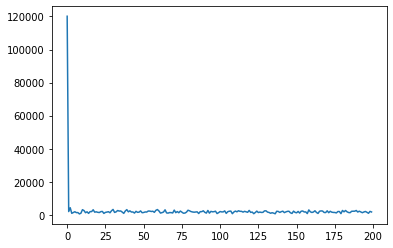

In [ ]:
plt.figure()
# plt.plot(D_loss[0:-1:918])
plt.plot(G_loss[0:-1:918])